![](imagenes/UC_FMRI.jpg)

---

---

***Andres Eduardo Aracena Rangel***

*Estudiante del programa del Magister en Física Médica*

---

---

El siguiente Script de Python forma parte del trabajo especial de grado.

Profesora Guía:

*PhD María Daniela Cornejo*

---

---

Imagenes de fMRI extraidas de OpenNeuro:

- [ds002422](https://openneuro.org/datasets/ds002422/versions/1.1.0)

---

---

Con referencia a:

 - [Nipype tutorial de Michael Notter](https://miykael.github.io/nipype_tutorial/)

Acronimos:

- CSF: Cerebrospinal Fluid (*líquido cefalorraquídeo*)
- GM: Gray Matter (*materia gris*)
- WM: White Matter (*materia blanca*)

# Flujo Trabajo de Preprocesamiento - con iterable de mask_ref

## Importamos Librerias

In [1]:
import time # medir el tiempo de ejecución de nuestros programas
start = time.process_time()
inicio = time.time()

In [2]:
import os # El módulo os nos permite acceder a funcionalidades dependientes del Sistema Operativo
from os.path import join as opj # Este método concatena varios componentes de ruta con exactamente un separador de directorio(‘/’)

from nipype import Node, Workflow, Function, SelectFiles, DataSink

from nipype.interfaces.fsl import ExtractROI, MCFLIRT, BET, FAST, Threshold, FLIRT, SliceTimer
from nipype.interfaces.spm import SliceTiming, Smooth, Realign
from nipype.algorithms.rapidart import ArtifactDetect

220521-05:29:56,596 nipype.utils WARNING:
	 A newer version (1.8.1) of nipy/nipype is available. You are using 1.7.0


In [3]:
from niflow.nipype1.workflows.fmri.fsl import create_susan_smooth

**nota:** En Nipype, puede escribir flujos de trabajo anidados , donde un flujo de trabajo secundario puede tomar el lugar de un nodo en un script determinado.

Nipype incluye flujos de trabajos preempaquetados, entre los que se encuentra `Susan` el cual realiza un proceso de filtrado gaussiano.

Al tratar de importar el paquete de `Susan` con

    from nipype.workflows.fmri.fsl import create_susan_smooth

en mi caso, me produce el siguiente error

    'NoneType' object is not iterable
    
por esta razon, importamos mediante

    from niflow.nipype1.workflows.fmri.fsl import create_susan_smooth

In [4]:
# MATLAB: especifique la ruta al SPM actual y el modo predeterminado de MATLAB
from nipype.interfaces.matlab import MatlabCommand
MatlabCommand.set_default_paths('/home/aracena/login/spm12')
MatlabCommand.set_default_matlab_cmd("matlab -nodesktop -nosplash")

Es importamte especificar la ruta del modulo SPM a utilizar, sino, al usar el modulo dara el siguiente error:

    stty: 'standard input': Inappropriate ioctl for device

## Definimos parámetros

In [5]:
# Ruta del directorio de la data
path_data = '/home/aracena/data/' 

'''
imagenes de OpenNeuro ds002422
'''
# Ruta donde reposan las imagenes de OpenNeuro ds002422
image_dir = opj(path_data,'ds002422')

# Ruta de archivo .json
path_json = opj(image_dir,'sub-01','func','sub-01_task-rest_bold.json')

'''
Ruta donde reposa el archivo bbr.sch de FSL
'''
path_bbr = '/home/aracena/fsl/etc/flirtsch/bbr.sch'

'''
Ruta donde se guardaran los resultados
'''
experiment_new = '/home/aracena/thesis_ds002422/'
path_output = opj(experiment_new,'01_fase1_extraccion_mask_brain','output')

'''
Ruta donde se guardaran los resultados del flujo de trabajo
'''
path_wf = opj(path_output, 'output_workflow')

# Crear la carpeta de salida
os.system('mkdir -p %s'%path_output)

'''
Indicamos los mapas de probabilidad o máscaras que vamos a procesar.
En este notebook, los mapas de probabilidad se extraen con la interfaz FAST de fsl; el resultado de esta
interfaz es una lista de archivos, es decir, [[pve0], [pve1], [pv2]], siendo

    pve0 = CSF
    pve1 = GM
    pve2 = WM

Debemos seleccionar solo los mapas de probabilidad que deseamos procesar, indicando las 
máscara de referencia (mask_ref), que normalmente es la la máscara de wm, y la máscara de extracción (mask_ext),
es decir, la máscara que se aplicara a la imagen funcional para extraer los datos. Debemos indicar 0,1,2 para 
las máscaras de CSF,GM,WM respectivamente. Por ejemplo, queremos mask_ref = WM y mask_extr = CSF, se ingresa:
    
    mask_ref = 2
    mask_ext = 0
'''
mask_ref = 2

# Indicamos en una lista, las mascaras externas que deseamos para la extracción
mask_ext = [0,1,2]

## Definimos funciones

### Función para extraer orden de adquisión de los cortes de la imagen

In [6]:
'''
Funcion para extraer el orden de adquisión de los cortes de la imagen.

Inputs:

- json_arch: archivo .json

Output:

- slice_order: orden de adqusión de los cortes
- TR: tiempo de repetición
- number_of_slices: numero de slices
'''
 
def order_slice(json_arch):
    import json as json
    with open(json_arch, 'rt') as fp:
        task_info = json.load(fp)
    
    '''
    Extraemos información del arhivo .json
    '''
    # tiempo de repeticion
    TR = task_info['RepetitionTime']
    # tiempo de adquisión de cortes
    slice_timing = task_info['SliceTiming']
    
    '''
    Procesamos data extraida del archivo .json
    '''
    # Numero de slices
    number_of_slices = len(slice_timing)
    # Tiempo en adquirir primer corte
    time_first = TR/number_of_slices
    # Valor minimo de slice_timing
    mini = min(slice_timing)
    # Valor maximo de slice_timing
    maxi = max(slice_timing)
    # Primer valor de slice_timing
    prim = slice_timing[0]
    # Segundo valor de slice_timing
    segu = slice_timing[1]

    if prim == mini:
        if segu == mini+time_first:
          print('Orden de adquisición de cortes secuenciales ascendente')
          slice_order = list(range(1, number_of_slices+1, 1))      
        else:
          print('Orden de adquisición de cortes intercalados 1-1')
          slice_order = list(range(1, number_of_slices+1, 2)) + list(range(2, number_of_slices+1, 2))      
    else:
        if segu == maxi - time_first:
          print('Orden de adquisición de cortes secuenciales descendente')
          slice_order = list(range(snumber_of_slices,0 , -1))
        else:
          print('Orden de adquisición de cortes intercalados 1 no 1')
          slice_order = list(range(2, number_of_slices+1, 2))+list(range(1, number_of_slices+1, 2))
    
    print(slice_timing)
    
    return slice_order,TR, number_of_slices

## Especificar flujo de entrada y salida

Especificamos dónde se pueden buscar y recopilar archivos del disco duro como datos de entrada, y cómo etiquetralos y guardar los datos de salida. 

En este notebook utilizaremos:

    recopilar --> SelectFiles
    almacenar --> DataSink


### Nodo SelectFiles

In [7]:
'''
Plantilla de cadena con cadenas basadas en {}
'''

# La entrada template indica la plantilla de cadena que debe coincidir en el directorio indicado a buscar
templates = {'anat': '{subject_id}/anat/sub-01_T1w.nii', 
             'func': '{subject_id}/func/sub-01_task-rest_bold.nii.gz'}

'''
Creamos el nodo SelectFiles
'''
selectfiles = Node(SelectFiles(templates),
          name='selectfiles')

'''
Inputs
- Ubicación de la carpeta del conjunto de datos
- Cadenas de marcador de posición {}
'''
# La entrada base_directory indica en que directorio buscar
selectfiles.inputs.base_directory = image_dir

#Ingresamos la(s) cadena(s) de marcador de posición {} con valores
selectfiles.inputs.subject_id = 'sub-01'

### Nodo DataSink

In [8]:
datasink = Node(DataSink(base_directory = path_output,
                         container = "datasink"),
                name="datasink")

# Definir cadenas de sustitución
substitutions = [('_mask_ext_0', 'mask_ext_csf'),
                 ('_mask_ext_1', 'mask_ext_gm'),
                 ('_mask_ext_2', 'mask_ext_wm'),
                 ('detrend.nii.gz', 'fmri_rest_prepro.nii.gz'),
                 ('_smooth0', 'smoooth'),
                 ('_mask_func0', 'mask_func'),                 
                 ('_thresh', 'threshold')
                ]

# Alimente las cadenas de sustitución al nodo DataSink
datasink.inputs.substitutions = substitutions

## Flujo de trabajo - preparación imagen funcional

### Nodo Function (Descomprimir archivos .gz)

Por lo general, la data que se encuentra alojada en OpenNeuro se encuentra en formato comprimido  '.gz', sin embargo, la data para ser procesada en la canalización de preprocesamiento debe estar descomprimida y en formato  '.nifti'. Se crea una función con modulo de Nipype Gunzip, donde verifica la extensión y descomprime si es '.gz'.

In [9]:
def gunzip_func(file):
    from nipype import Node
    from nipype.algorithms.misc import Gunzip
    veri = file
    a = veri.find('.gz')
    if a < 0:
        out_file = file
    else:
        gunzip = Gunzip(in_file=veri)
        out_file = gunzip.run().outputs.out_file
    return out_file

gunzip_func = Node(Function(input_file=["file"],
                       output_names=["out_file"],
                       function=gunzip_func),
              name='gunzip_func')

In [10]:
def gunzip_anat(file):
    from nipype import Node
    from nipype.algorithms.misc import Gunzip
    veri = file
    a = veri.find('.gz')
    if a < 0:
        out_file = file
    else:
        gunzip = Gunzip(in_file=veri)
        out_file = gunzip.run().outputs.out_file
    return out_file

gunzip_anat = Node(Function(input_file=["file"],
                       output_names=["out_file"],
                       function=gunzip_anat),
              name='gunzip_anat')

In [11]:
from nipype.interfaces.fsl import ExtractROI, MCFLIRT, BET, FAST, Threshold, FLIRT, SliceTimer

### Nodo ExtractROI (Eliminar escaneos ficticios)

Las imágenes funcionales son obtenidas como protocolo con una cantidad de escaneos ficticios al principio, los cuales deben ser extraidos/eliminados del conjunto de imagenes funcionales adquiridas.

In [12]:
extract = Node(ExtractROI(t_min=4, t_size=-1, output_type='NIFTI'),
               name="extract")

### Nodo SliceTiming (Corrección del tiempo de corte )


Para corregir la adquisición de los cortes de los volúmenes, utilizaremos SliceTiming. Los datos de entrada, inputs,

    num_slices,
    ref_slice,
    slice_order,
    time_repetition,
    time_acquisition
    
son extraídos del archivo '.json' al ingresarlo en la función

    def order_slice(json_arch)


In [13]:
# Funcion para extraer el orden de adquisión de las cortes de la imagen
res_fun = order_slice(path_json)

slice_order = res_fun[0]
TR = res_fun[1]
number_of_slices = res_fun[2]

# SliceTimer - correct for slice wise acquisition
slicetime = Node(SliceTimer(index_dir=False,
                             interleaved=True,
                             output_type='NIFTI',
                             time_repetition=TR),
                  name="slicetime")

Orden de adquisición de cortes intercalados 1 no 1
[1.5375, 0, 1.6225, 0.085, 1.7075, 0.1725, 1.7925, 0.2575, 1.8775, 0.3425, 1.9625, 0.4275, 2.05, 0.5125, 2.135, 0.5975, 2.22, 0.6825, 2.305, 0.77, 2.39, 0.855, 2.475, 0.94, 2.56, 1.025, 2.6475, 1.11, 2.7325, 1.195, 2.8175, 1.28, 2.9025, 1.3675, 2.9875, 1.4525]


### Nodo MCFLIRT - VOL (Corrección de movimiento)

Para corregir el movimiento en el escáner, usaremos FSL MCFLIRT.

**NOTA:** Al ejecutar el nodo MCFLIRT necesitamos dos outputs para el procesamiento, los cuales son:

    out_file: nos entrega una matriz 4D con la corrección del movimiento
    mean_img: nos entrega un volumen, matriz 3D, promedio con la corrección del movimiento

Si la versión de `FSL` instalado no es la versión 5, al ejecutar el flujo de trabajo conducirá a un error que nos indica que no se encuentra el archivo de `mean_img`, arrojando un error como:

    FileNotFoundError: No such file or directory /opt/home/aracena/thesis_practica/tips_nipype/16_workflow_preprocesamiento/output_prefunc/output_workflow/work_preproc_func/mcflirt/sub-01_task-rest_bold_roi_st_mcf_mean_reg.nii.gz' for output 'mean_img' of a MCFLIRT interface
    
Esto se debe, como en mi caso que tengo instalado FSL versión 6.0, al sobrescribir el archivo de procesamiento de mean_img, NO suprime la extensión previa, creando un archivo con la extensión copiado dos veces, como se observa en la figura:

![](imagenes/error_MCFLIRT.png)

Este es un resultado previo a este notebook y arrojando el error. En este caso, marcaremos en negrita lo previamente explicado

   sub-01-task-rest_bold_roi_st_mcf**.nii.gz**_mean_reg**.nii.gz**

La solución para obtener estos dos outputs, fue obtenerlos separadamente, donde el output `out_file` lo obtendremos mediante el nodo MCFLIRT, y el output `mean_img` lo obtendremos con una nodo Function MCFLIRT. Detalles sobre cómo se elaboro este nodo Function MCFLIRT, puede revisar el notebook **aplicacion_NODO_funcion_MCFLIRT.ipynb**


    

In [14]:
#MCFLIRT.help()

In [15]:
'''
Creamos el Nodo MCFLIRT - VOL
'''

mcflirt_vol = Node(MCFLIRT(), name="mcflirt_vol")

# inputs
mcflirt_vol.inputs.save_plots=True

### Función MCFLIRT-MEAN

In [16]:
def crear_mean_img(archivo,img_func,path_wf): 
    import os, pathlib, re
    from os.path import join as opj
    from nipype.interfaces.fsl import MCFLIRT
    
    '''
    Sustraemos extensión de archivo
    '''
    print('-----\n', archivo)
    ext = '.gz'
    img_modi = archivo

    while ext != '':
        # extraemos la extencion del archivo
        path = pathlib.Path(img_modi)
        ext = path.suffix
        #realizamos la sustracción de la extensión del archivo
        img_modi = re.sub(ext,"",img_modi)
        ext = pathlib.Path(img_modi).suffix
        new_name = pathlib.Path(img_modi).name

    '''
    creamos el archivo sin extension y su ruta
    '''
    path_out_file = opj(path_wf,new_name)
    os.system('touch %s'%path_out_file)
        
    '''
    ejecutamos la interfaz MCFLRIT - MEAN
    '''
    mfmean = MCFLIRT()
    mfmean.inputs.in_file = img_func
    mfmean.inputs.out_file = path_out_file
    mfmean.inputs.mean_vol=True
    out_file = mfmean.run().outputs.mean_img
          
    return out_file

'''
Creamos el nodo Fuction de MCFLIRT-MEAN
'''

mcflirt_mean = Node(Function(input_file=['archivo','img_func', 'path_wf'],
                            output_names=['mean_img'],
                            function=crear_mean_img),
              name='mcflirt_mean')

mcflirt_mean.inputs.path_wf = path_wf

### Nodo ArtifactDetect (Detección de artefactos)

La herramienta `ArtifactDetect`es útil para detectar valores atípicos de movimiento e intensidad en las imágenes funcionales. Los inputs significa lo siguiente:

- **norm_threshold** - Umbral para usar para detectar valores atípicos relacionados con el movimiento cuando se usa movimiento compuesto
- **zintensity_threshold** - Uso del umbral Z de intensidad para detectar imágenes que se desvían de la media
- **mask_type** - Tipo de máscara que debe usarse para enmascarar los datos funcionales. spm_global utiliza un cálculo similar a spm_global para determinar la máscara cerebral
- **parameter_source** - Fuente de parámetros de movimiento
- **use_differences** - Si desea utilizar diferencias entre estimaciones de movimiento sucesivo (primer elemento) y parámetro de intensidad (segundo elemento) para determinar valores atípicos

In [17]:
# Artifact Detection - determines outliers in functional images
art = Node(ArtifactDetect(norm_threshold=2,
                          zintensity_threshold=3,
                          mask_type='spm_global',
                          parameter_source='FSL',
                          use_differences=[True, False],
                          plot_type='svg'),
           name="art")

### Nodo Smooth

La herramienta `Smooth` es útil para el suavizado gaussiano 3D de los volúmenes de imagen.

In [18]:
# Smooth - image smoothing
smooth = Node(Smooth(), name="smooth")
#smooth.iterables = ("fwhm", fwhm)

stty: 'standard input': Inappropriate ioctl for device


## Flujo de trabajo - preparacion imagen anatomica

### Nodo BET

Extracción del craneo de la imagen anatomica.

Con los notebook previos, *workflow_BET_iterable_frac.ipynb* y *workflow_BET_iterable_robust.ipynb* usaremos los siguientes inputs:

In [19]:
'''
Creamos el nodo BET
'''
skullstrip = Node(BET(output_type='NIFTI_GZ'),
                name="skullstrip")
# Inputs Nodo
skullstrip.inputs.robust = True
skullstrip.inputs.frac = 0.6

### Nodo FAST (Segmentación de imagen anatómica)

Para crear los mapas de probabilidad para la CSF, GM y WM, usamos la interfaz `NewSegment` de SPM.

In [20]:
#FAST.help()

In [21]:
'''
Creamos el nodo FAST
'''

segmentation = Node(FAST(output_type='NIFTI_GZ'),
                name="segmentation")

## Flujo de trabajo - Corregistro

### Nodo Function (Selección de mapas de probabilidad)

Declaramos una función auxiliar para seleccionar el mapa de probabilidad de CSF y WM. Debido a que el campo de salida del nodo *segmentation* nos da una lista de archivos, es decir, [[pve0], [pve1], [pv2]], siendo

    pve0 = CSF
    pve1 = GM
    pve2 = WM

Por lo tanto, usando las siguiente función, podemos seleccionar solo los mapas de probabilidad que desamos.

#### Seleccionar mapa de probabilidad (mp) de REFERENCIA

In [22]:
# Seleccione el mp de CSF de la salida del nodo segmentation
def get_ref(files, mask_ref):
    return files[mask_ref]

# Creamos Nodo
get_mask_ref = Node(Function(input_names=['files', 'mask_ref'],
                       output_names=["output_file"],
                       function=get_ref),
              name='get_mask_ref')

get_mask_ref.inputs.mask_ref = mask_ref

#### Seleccionar mapa de probabilidad (mp) de EXTRACCION

In [23]:
# Seleccione el mp de WM de la salida del nodo segmentation
def get_ext(files, mask_ext):
    return files[mask_ext]

# Creamos Nodo
get_mask_ext = Node(Function(input_names=['files', 'mask_ext'],
                       output_names=['output_file'],
                       function=get_ext),
              name='get_mask_ext')

get_mask_ext.iterables = ('mask_ext', mask_ext)

### Nodo Threshold (Creación de mascara binaria)

Creamos una máscara binaria a partir del mapa de probabilidad de WM. Esto se puede hacer mediante la interfaz `Threshold` de FSL.

Esta mascara binaria servirá para guiar el corregistro entre la imagen anatomica y funcional, mediante el nodo `coreg_bbr` que se definira más adelante.

In [24]:
# Threshold - Threshold WM probability image
threshold = Node(Threshold(thresh=0.5,
                           args='-bin',
                           output_type='NIFTI_GZ'),
                name="threshold")

In [25]:
#Threshold.help()

### Nodo FLIRT (Calcular Matriz de Corregistro)

Como siguiente paso, nos aseguraremos de que las imágenes funcionales se registren conjuntamente con la imagen anatómica. Para ello, usaremos la interfaz `FLIRT` de FSL . Como acabamos de crear un mapa de probabilidad de CSF, podemos usarlo junto con la función de costo del registro basado en límites (BBR) para optimizar el corregistro de la imagen. Como algunas notas útiles ...

    utilizar un grado de libertad  (dof) de 6
    especificar la función de costo (cost) como bbr
    utilizar el schedule = path_bbr (definida en los parámetros)

In [26]:
# FLIRT - pre-alineación de imágenes funcionales a imágenes anatómicas
coreg_pre = Node(FLIRT(dof=6, output_type='NIFTI_GZ'),
                 name="coreg_pre")

# FLIRT - corregistro de imágenes funcionales a imágenes anatómicas con BBR
coreg_bbr = Node(FLIRT(dof=6,
                       cost='bbr',
                       schedule=path_bbr,
                       output_type='NIFTI_GZ'),
                 name="coreg_bbr")

### Nodo FLIRT 2 (Aplicar Matriz de Corregistro a la imagen funcional)

Ahora que conocemos la matriz de coregistro para superponer correctamente la imagen media funcional en la anatomía específica del sujeto, debemos aplicar el coregistro a toda la serie de tiempo. Esto se puede lograr con la interface `FLIRT` de FSL de la siguiente manera:

In [27]:
# Especificar el voxel resolución isométrica que desea después de coregistration 
desired_voxel_iso = 4

# Aplicar coregistration warp a imágenes funcionales 
applywarp = Node(FLIRT(interp='spline',
                       apply_isoxfm=desired_voxel_iso,
                       output_type='NIFTI'),
                 name="applywarp")

**Importante :** como puede observar, se especifica una variable `desired_voxel_iso`. Esto es muy importante en esta etapa; de lo contrario `FLIRT`, transformará sus imágenes funcionales a una resolución de la imagen anatómica, lo que aumentará drásticamente el tamaño del archivo (por ejemplo, de 1 a 10 GB por archivo). Si no desea cambiar la resolución del vóxel, use el parámetro adicional `no_resample=True`. Importante, para que esto funcione, aún necesita definir `apply_isoxfm=desired_voxel_iso`.

### Nodo Susan (Suavizado)

El siguiente paso es suavizar la imagen. La forma más sencilla de hacer esto es utilizar la función `Smooth` de `FSL` o `SPM`. Tenga en cuenta que esta vez, estamos importando un flujo de trabajo en lugar de una interfaz.

In [28]:
susan = create_susan_smooth(name='susan')
susan.inputs.inputnode.fwhm = 4

In [29]:
susan.outputs


inputnode = 
fwhm = None
in_files = None
mask_file = None

mask = 
out_file = None

meanfunc2 = 
out_file = None

median = 
out_stat = None

merge = 
out = None

multi_inputs = 
cart_btthresh = None
cart_fwhm = None
cart_in_file = None
cart_usans = None

outputnode = 
smoothed_files = None

smooth = 
smoothed_file = None


In [30]:
#create_susan_smooth?

## Flujo de trabajo - Crear máscara binaria

Hay muchos enfoques posibles sobre cómo enmascarar sus imágenes funcionales. Uno de ellos no lo es en absoluto, uno tiene una simple máscara cerebral y uno que solo considera cierto tipo de tejido cerebral, por ejemplo, la materia gris.

Para este Script, queremos crear una máscara de liquido cefalorraquídeo dilatada. Para ello necesitamos:

- Vuelva a muestrear el mapa de probabilidad de csf a la misma resolución que las imágenes funcionales
- Umbral de este mapa de probabilidad remuestreado en un valor específico
- Dilata esta máscara con algunos voxels para hacer que la máscara sea menos conservadora y más inclusiva.

El primer paso se puede realizar de muchas formas (por ejemplo, utilizando `mri_convert` de freesurfer, nibabel) en nuestro caso, usaremos `FLIRT` de FSL. El truco consiste en utilizar la máscara de probabilidad, como archivo de entrada y como archivo de referencia.

### Nodo FLIRT  3 (Máscara csf)

In [31]:
# Initiate resample node
resample = Node(FLIRT(apply_isoxfm=desired_voxel_iso,
                      output_type='NIFTI'),
                name="resample")

### Nodo Threshold 2 (Mascara csf)

Afortunadamente, el segundo y tercer paso se pueden realizar con un solo nodo. Podemos tomar casi el mismo nodo `Threshold` que el anterior. Solo necesitamos agregar otro argumento adicional: `-dilF-` que aplica un filtrado máximo de todos los vóxeles.

In [32]:
# Threshold - Imagen de probabilidad de CSF umbral 
mask_EXT  =  Node ( Threshold (args = '-bin -dilF',
                               output_type = 'NIFTI' ), 
                name = "mask_EXT" )

mask_EXT.iterables = ('thresh', [0.5,0.95,0.97,0.99])

### Nodo Function (selección de mapa de probabilidad de CSF)

Función `get_csf(files)` definida en Flujo de trabajo-Corregistro

## Flujo de trabajo - Aplicar la máscara binaria

Para aplicar la máscara a las imágenes funcionales suavizadas, usaremos la interfaz `ApplyMask` de FSL.

**Importante:** el flujo de trabajo de Susan proporciona una lista de archivos, es decir, [smoothed_func.nii], en lugar de solo el nombre del archivo directamente. Si usáramos un NodO para `ApplyMask`, se produciría el siguiente error:

    TraitError: The 'in_file' trait of an ApplyMaskInput instance must be an existing file name, but a value of ['/output/work_preproc/susan/smooth/mapflow/_smooth0/asub-07_ses-test_task-fingerfootlips_bold_mcf_flirt_smooth.nii.gz'] <class 'list'> was specified.


Para evitar esto , usaremos a `MapNode` y especificaremos `in_file` en el input `iterfield`.Así, el nodo es capaz de manejar una lista de entradas, ya que sabrá que tiene que aplicarse de forma iterativa a la lista de entradas.

### Nodo ApplyMask

In [33]:
from nipype import MapNode
from nipype.interfaces.fsl import ApplyMask

mask_func = MapNode(ApplyMask(output_type='NIFTI'),
                    name="mask_func",
                    iterfield=["in_file"])

### Nodo TSNR (Eliminar tendencias lineales en imágenes funcionales)

Usemos el módulo `TSNR` de Nipype para eliminar tendencias lineales y cuadráticas en las imágenes funcionales suavizadas. Para ello, solo tienes que especificar el parámetro `regress_poly` en el inicio del nodo.

In [34]:
from nipype.algorithms.confounds import TSNR

detrend = Node(TSNR(regress_poly=2), name="detrend")

#### Para la fMRI

In [35]:
from nipype.algorithms.confounds import TSNR

detrend_fmri = Node(TSNR(regress_poly=2), name="detrend_fmri")

## Definimos los Flujos de trabajo

In [36]:
# Flujo de trabajo de Preparacion - imagen func
prefunc = Workflow(name = 'work_preproc_func', base_dir = path_wf)

# Flujo de trabajo de Preparación - imagen anat
preanat = Workflow(name = 'work_preproc_anat', base_dir = path_wf)

# Flujo de trabajo de corregistro
prereg = Workflow(name = 'work_preproc_corregistro', base_dir = path_wf)

### Conectamos Nodos

In [37]:
prefunc.connect(gunzip_func, 'out_file', extract, 'in_file')
prefunc.connect(extract, 'roi_file', slicetime, 'in_file')
prefunc.connect(slicetime,'slice_time_corrected_file', mcflirt_vol, 'in_file')
prefunc.connect(slicetime,'slice_time_corrected_file', mcflirt_mean, 'img_func')
prefunc.connect(mcflirt_vol, 'out_file', mcflirt_mean, 'archivo')

In [38]:
preanat.connect(gunzip_anat, 'out_file', skullstrip, 'in_file')
preanat.connect(skullstrip, 'out_file', segmentation, 'in_files')
# creacion mascara wm-anat
preanat.connect(segmentation, 'partial_volume_files', get_mask_ref, 'files'),
preanat.connect(get_mask_ref, 'output_file', threshold, 'in_file')

In [39]:
prereg.connect(preanat, 'gunzip_anat.out_file', coreg_bbr, 'reference')
prereg.connect(preanat, 'gunzip_anat.out_file', applywarp, 'reference')
prereg.connect(preanat, 'skullstrip.out_file', coreg_pre, 'reference')
prereg.connect(preanat, 'threshold.out_file', coreg_bbr, 'wm_seg')
prereg.connect(prefunc, 'mcflirt_vol.out_file', applywarp, 'in_file')
prereg.connect(prefunc, 'mcflirt_mean.mean_img', coreg_pre, 'in_file')
prereg.connect(prefunc, 'mcflirt_mean.mean_img', coreg_bbr, 'in_file')
prereg.connect(coreg_pre, 'out_matrix_file', coreg_bbr, 'in_matrix_file')
prereg.connect(coreg_bbr, 'out_matrix_file', applywarp, 'in_matrix_file')
prereg.connect(applywarp, 'out_file', susan, 'inputnode.in_files')
#creacion mascara extraccion-anat
prereg.connect(preanat, 'segmentation.partial_volume_files', get_mask_ext, 'files')
prereg.connect(get_mask_ext, 'output_file', resample, 'in_file')
prereg.connect(get_mask_ext, 'output_file', resample, 'reference')
prereg.connect(resample, 'out_file', mask_EXT, 'in_file')
prereg.connect(mask_EXT, 'out_file', susan, 'inputnode.mask_file')

In [40]:
prereg.connect(selectfiles, 'anat', preanat, 'gunzip_anat.file')
prereg.connect(selectfiles, 'func', prefunc, 'gunzip_func.file')

prereg.connect(susan, 'outputnode.smoothed_files', mask_func, 'in_file')
prereg.connect(mask_EXT, 'out_file', mask_func, 'mask_file')
prereg.connect(mask_func, 'out_file', detrend, 'in_file')
prereg.connect(detrend, 'detrended_file', datasink, 'masks_brain')
prereg.connect(susan, 'outputnode.smoothed_files', datasink, 'fmri_smooth')
prereg.connect(applywarp, 'out_file', datasink, 'fmri_sin_smooth')
prereg.connect(mask_func, 'out_file', datasink, 'masks_brain_sin_detrend')

prereg.connect(susan, 'outputnode.smoothed_files', detrend_fmri, 'in_file')
prereg.connect(detrend_fmri, 'detrended_file', datasink, 'fmri_detrend')



prereg.connect(preanat, 'segmentation.partial_volume_files', datasink, 'mask_files')

### Visualizamos el Flujo de trabajo

220521-05:30:09,49 nipype.workflow INFO:
	 Generated workflow graph: /home/aracena/thesis_ds002422/01_fase1_extraccion_mask_brain/output/output_workflow/work_preproc_corregistro/graph.png (graph2use=colored, simple_form=True).


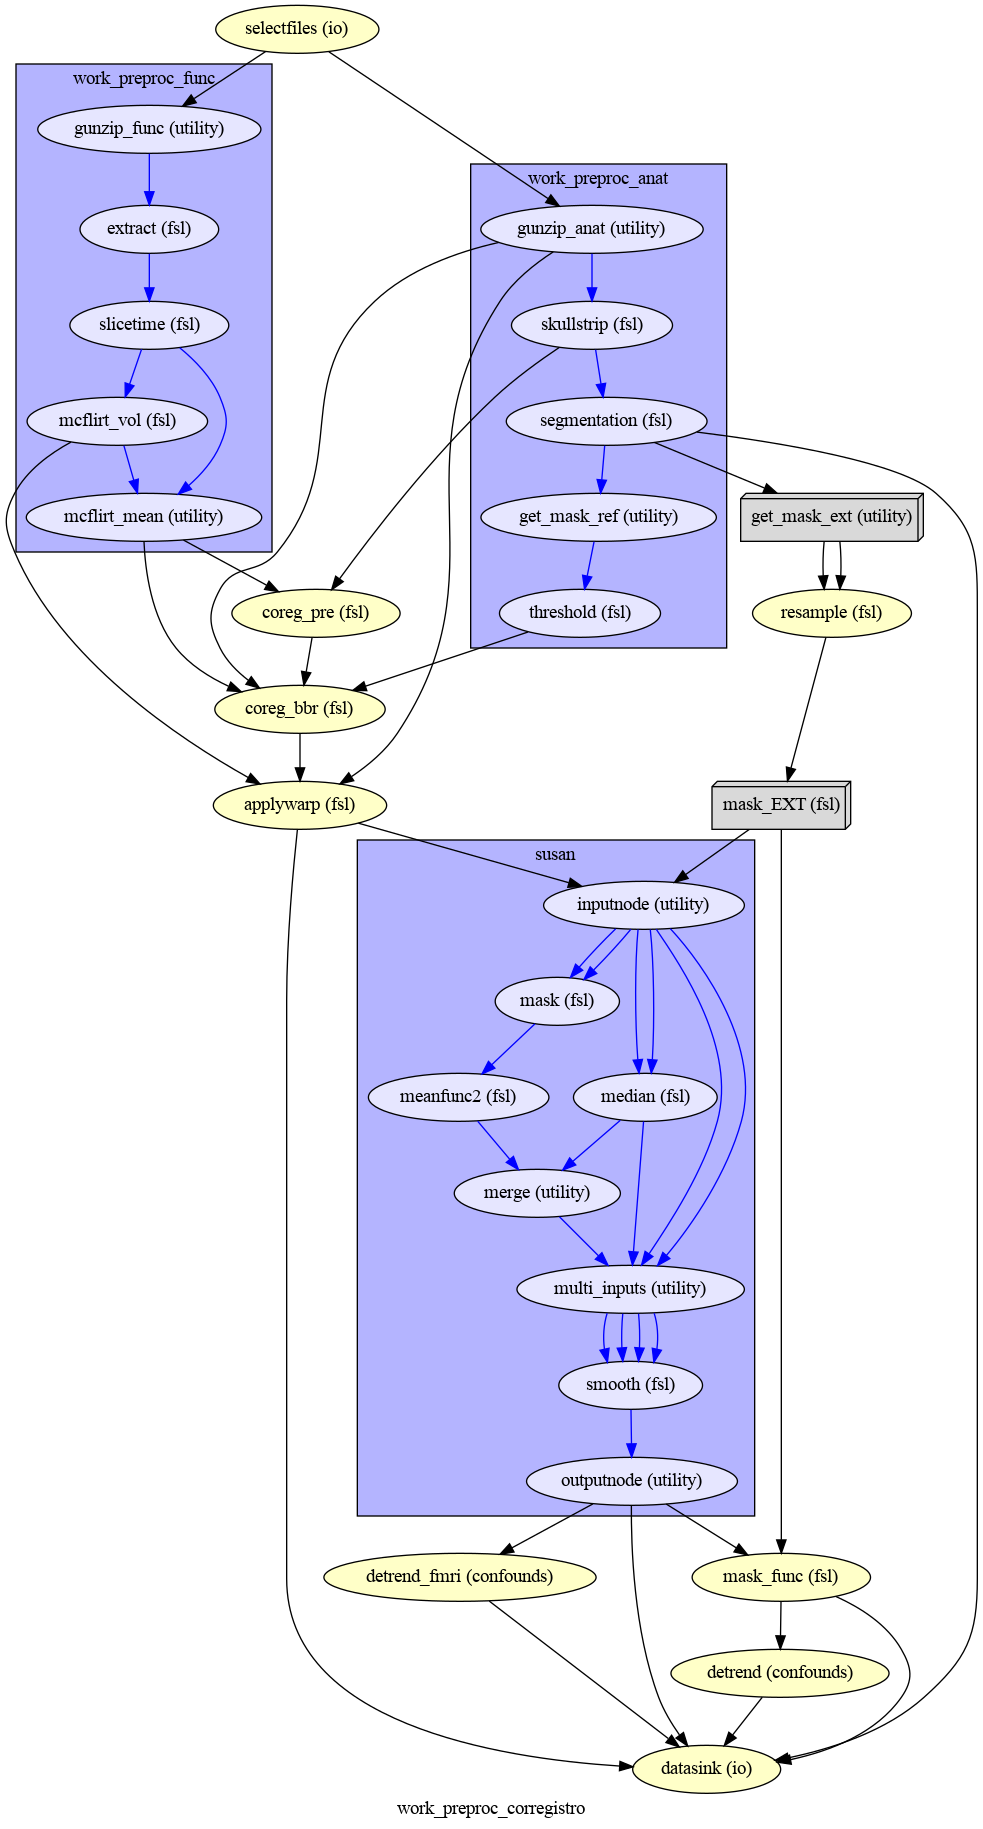

In [41]:
# Create preproc output graph
prereg.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=path_wf+'/work_preproc_corregistro/graph.png')

220521-05:30:09,879 nipype.workflow INFO:
	 Generated workflow graph: /home/aracena/thesis_ds002422/01_fase1_extraccion_mask_brain/output/output_workflow/work_preproc_corregistro/graph.png (graph2use=flat, simple_form=True).


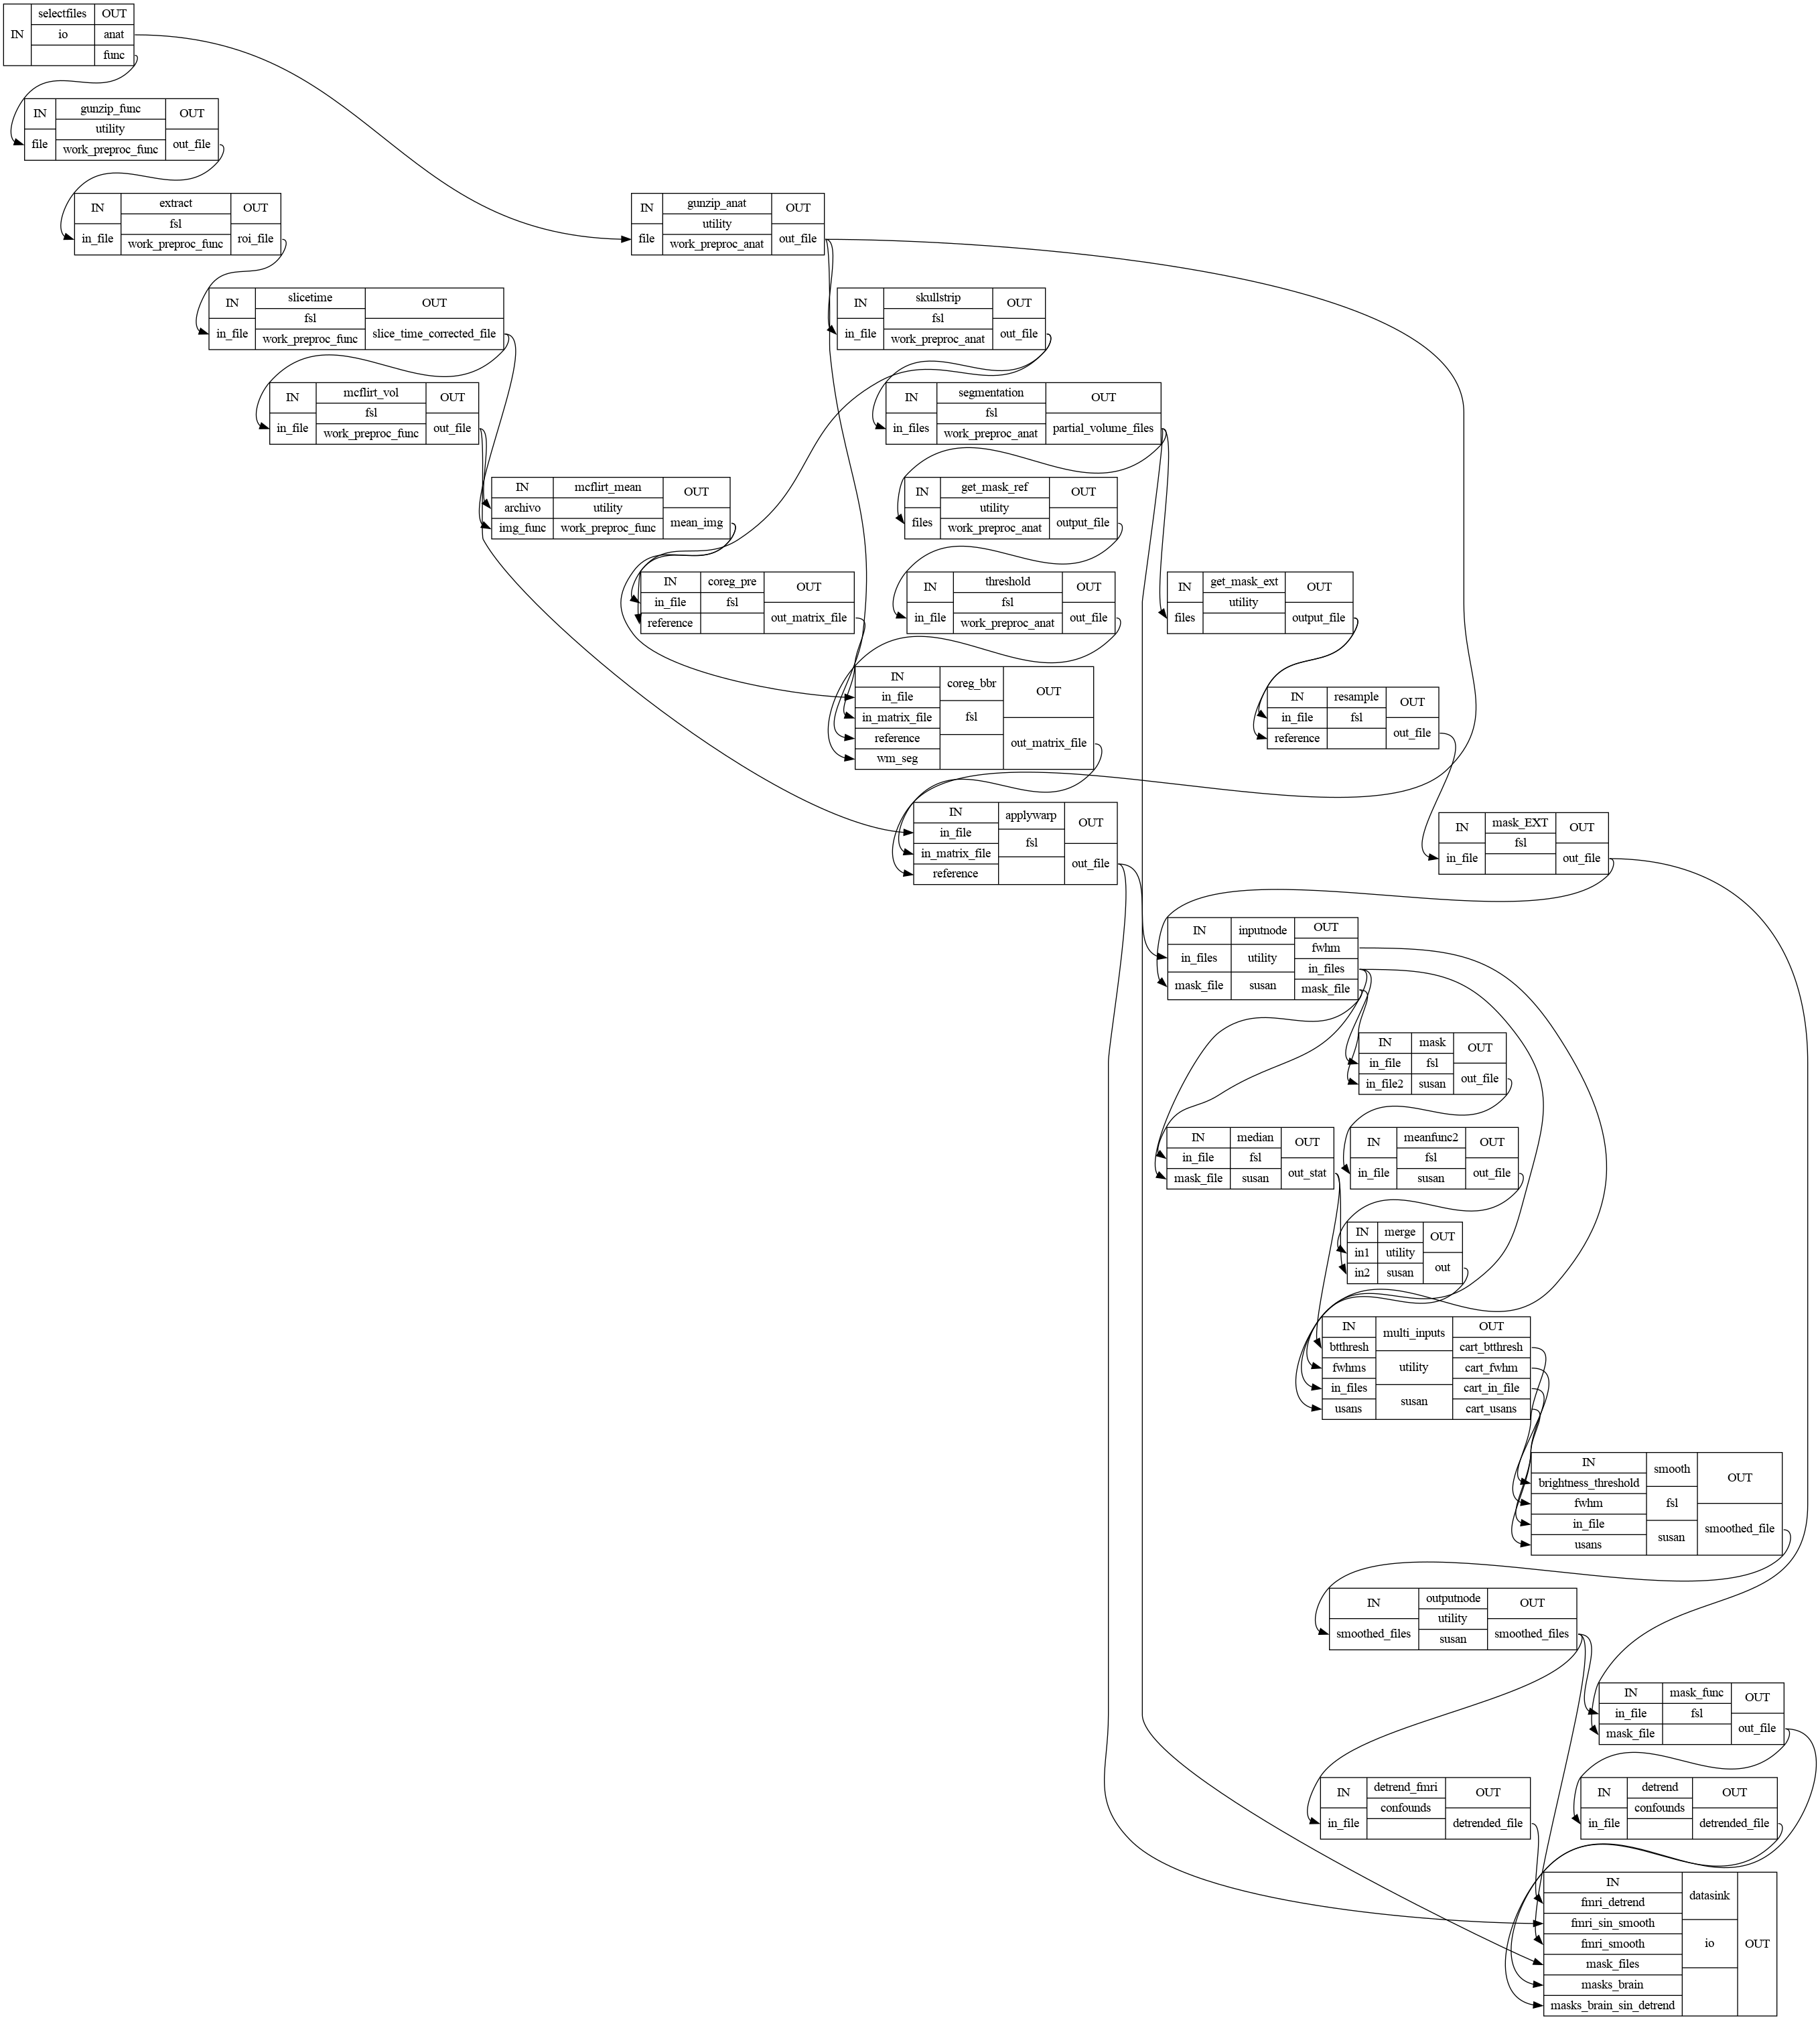

In [42]:
# Otra visualización del flujo de trabajo

prereg.write_graph(graph2use='flat', format='png', simple_form=True)
Image(filename=path_wf+'/work_preproc_corregistro/graph_detailed.png')

### Ejecutamos el flujo de trabajo

In [43]:
prereg.run('MultiProc', plugin_args={'n_procs': 8})

220521-05:30:09,923 nipype.workflow INFO:
	 Workflow work_preproc_corregistro settings: ['check', 'execution', 'logging', 'monitoring']
220521-05:30:10,45 nipype.workflow INFO:
	 Running in parallel.
220521-05:30:10,51 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 13.99/13.99, Free processors: 8/8.
220521-05:30:10,121 nipype.workflow INFO:
	 [Node] Setting-up "work_preproc_corregistro.selectfiles" in "/opt/home/aracena/thesis_ds002422/01_fase1_extraccion_mask_brain/output/output_workflow/work_preproc_corregistro/selectfiles".
220521-05:30:10,127 nipype.workflow INFO:
	 [Node] Executing "selectfiles" <nipype.interfaces.io.SelectFiles>
220521-05:30:10,132 nipype.workflow INFO:
	 [Node] Finished "selectfiles", elapsed time 0.001645s.
220521-05:30:12,53 nipype.workflow INFO:
	 [Job 0] Completed (work_preproc_corregistro.selectfiles).
220521-05:30:12,57 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 13.99/1

220521-05:30:36,191 nipype.workflow INFO:
	 [Job 75] Cached (work_preproc_corregistro.susan.merge).
220521-05:30:36,198 nipype.workflow INFO:
	 [Job 85] Cached (work_preproc_corregistro.susan.merge).
220521-05:30:36,216 nipype.workflow INFO:
	 [Job 94] Cached (work_preproc_corregistro.susan.meanfunc2).
220521-05:30:36,223 nipype.workflow INFO:
	 [Job 102] Cached (work_preproc_corregistro.susan.median).
220521-05:30:38,81 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 16 jobs ready. Free memory (GB): 13.99/13.99, Free processors: 8/8.
220521-05:30:38,168 nipype.workflow INFO:
	 [Job 37] Cached (work_preproc_corregistro.susan.smooth).
220521-05:30:38,179 nipype.workflow INFO:
	 [Job 47] Cached (work_preproc_corregistro.susan.smooth).
220521-05:30:38,194 nipype.workflow INFO:
	 [Job 57] Cached (work_preproc_corregistro.susan.smooth).
220521-05:30:38,208 nipype.workflow INFO:
	 [Job 67] Cached (work_preproc_corregistro.susan.smooth).
220521-05:30:38,217 nipype.workflow INFO:
	 [J

220521-05:30:52,101 nipype.workflow INFO:
	 [Job 68] Completed (work_preproc_corregistro.detrend_fmri).
220521-05:30:52,104 nipype.workflow INFO:
	 [Job 40] Completed (work_preproc_corregistro.detrend).
220521-05:30:52,107 nipype.workflow INFO:
	 [Job 50] Completed (work_preproc_corregistro.detrend).
220521-05:30:52,111 nipype.workflow INFO:
	 [Job 70] Completed (work_preproc_corregistro.detrend).
220521-05:30:52,118 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 17 jobs ready. Free memory (GB): 13.99/13.99, Free processors: 8/8.
220521-05:30:52,215 nipype.workflow INFO:
	 [Node] Setting-up "work_preproc_corregistro.datasink" in "/opt/home/aracena/thesis_ds002422/01_fase1_extraccion_mask_brain/output/output_workflow/work_preproc_corregistro/_mask_ext_2/_thresh_0.99/datasink".
220521-05:30:52,215 nipype.workflow INFO:
	 [Node] Setting-up "work_preproc_corregistro.datasink" in "/opt/home/aracena/thesis_ds002422/01_fase1_extraccion_mask_brain/output/output_workflow/work_preproc_

220521-05:30:52,271 nipype.interface INFO:
	 sub: /home/aracena/thesis_ds002422/01_fase1_extraccion_mask_brain/output/datasink/masks_brain/_mask_ext_2/_thresh_0.5/detrend.nii.gz -> /home/aracena/thesis_ds002422/01_fase1_extraccion_mask_brain/output/datasink/masks_brain/mask_ext_wm/threshold_0.5/fmri_rest_prepro.nii.gz
220521-05:30:52,276 nipype.interface INFO:
	 sub: /home/aracena/thesis_ds002422/01_fase1_extraccion_mask_brain/output/datasink/fmri_smooth/_mask_ext_2/_thresh_0.5/_smooth0/sub-01_task-rest_bold_roi_st_mcf_flirt_smooth.nii.gz -> /home/aracena/thesis_ds002422/01_fase1_extraccion_mask_brain/output/datasink/fmri_smooth/mask_ext_wm/threshold_0.5/smoooth/sub-01_task-rest_bold_roi_st_mcf_flirt_smooth.nii.gz
220521-05:30:52,265 nipype.workflow INFO:
	 [Node] Finished "datasink", elapsed time 0.039859s.
220521-05:30:52,277 nipype.workflow INFO:
	 [Node] Finished "datasink", elapsed time 0.023507s.
220521-05:30:52,282 nipype.workflow INFO:
	 [Node] Finished "datasink", elapsed time

220521-05:31:00,126 nipype.workflow INFO:
	 [Job 99] Completed (work_preproc_corregistro.mask_func).
220521-05:31:00,130 nipype.workflow INFO:
	 [Job 115] Completed (work_preproc_corregistro.susan.merge).
220521-05:31:00,137 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 10 jobs ready. Free memory (GB): 13.39/13.99, Free processors: 5/8.
                     Currently running:
                       * work_preproc_corregistro.detrend_fmri
                       * work_preproc_corregistro.detrend
                       * work_preproc_corregistro.detrend_fmri
220521-05:31:00,335 nipype.workflow INFO:
	 [Node] Setting-up "work_preproc_corregistro.datasink" in "/opt/home/aracena/thesis_ds002422/01_fase1_extraccion_mask_brain/output/output_workflow/work_preproc_corregistro/_mask_ext_1/_thresh_0.99/datasink".
220521-05:31:00,336 nipype.workflow INFO:
	 [Node] Setting-up "work_preproc_corregistro.detrend" in "/opt/home/aracena/thesis_ds002422/01_fase1_extraccion_mask_brain/output/ou

220521-05:31:02,323 nipype.workflow INFO:
	 [Node] Finished "datasink", elapsed time 0.074111s.
220521-05:31:02,311 nipype.workflow INFO:
	 [Node] Executing "_mask0" <nipype.interfaces.fsl.utils.ImageMaths>
220521-05:31:03,561 nipype.workflow INFO:
	 [Node] Finished "_median0", elapsed time 1.289021s.
220521-05:31:03,605 nipype.workflow INFO:
	 [Node] Finished "_mask0", elapsed time 1.316119s.
220521-05:31:03,655 nipype.workflow INFO:
	 [Node] Finished "_mask0", elapsed time 1.329253s.
220521-05:31:03,710 nipype.workflow INFO:
	 [Node] Finished "detrend_fmri", elapsed time 7.288639s.
220521-05:31:03,748 nipype.workflow INFO:
	 [Node] Finished "detrend", elapsed time 3.406126s.
220521-05:31:04,119 nipype.workflow INFO:
	 [Job 98] Completed (work_preproc_corregistro.detrend_fmri).
220521-05:31:04,120 nipype.workflow INFO:
	 [Job 100] Completed (work_preproc_corregistro.detrend).
220521-05:31:04,122 nipype.workflow INFO:
	 [Job 91] Completed (work_preproc_corregistro.datasink).
220521-05:

220521-05:31:08,202 nipype.workflow INFO:
	 [Node] Setting-up "work_preproc_corregistro.susan.multi_inputs" in "/opt/home/aracena/thesis_ds002422/01_fase1_extraccion_mask_brain/output/output_workflow/work_preproc_corregistro/susan/_mask_ext_0/_thresh_0.95/multi_inputs".
220521-05:31:08,201 nipype.workflow INFO:
	 [Node] Setting-up "work_preproc_corregistro.susan.multi_inputs" in "/opt/home/aracena/thesis_ds002422/01_fase1_extraccion_mask_brain/output/output_workflow/work_preproc_corregistro/susan/_mask_ext_0/_thresh_0.97/multi_inputs".
220521-05:31:08,203 nipype.workflow INFO:
	 [Node] Setting-up "work_preproc_corregistro.susan.merge" in "/opt/home/aracena/thesis_ds002422/01_fase1_extraccion_mask_brain/output/output_workflow/work_preproc_corregistro/susan/_mask_ext_0/_thresh_0.5/merge".
220521-05:31:08,207 nipype.workflow INFO:
	 [Node] Executing "multi_inputs" <nipype.interfaces.utility.wrappers.Function>
220521-05:31:08,207 nipype.workflow INFO:
	 [Node] Executing "multi_inputs" <nip

220521-05:31:34,226 nipype.workflow INFO:
	 [Node] Setting-up "work_preproc_corregistro.datasink" in "/opt/home/aracena/thesis_ds002422/01_fase1_extraccion_mask_brain/output/output_workflow/work_preproc_corregistro/_mask_ext_1/_thresh_0.5/datasink".
220521-05:31:34,237 nipype.workflow INFO:
	 [Node] Executing "datasink" <nipype.interfaces.io.DataSink>
220521-05:31:34,240 nipype.interface INFO:
	 sub: /home/aracena/thesis_ds002422/01_fase1_extraccion_mask_brain/output/datasink/masks_brain_sin_detrend/_mask_ext_1/_thresh_0.5/_mask_func0/sub-01_task-rest_bold_roi_st_mcf_flirt_smooth_masked.nii -> /home/aracena/thesis_ds002422/01_fase1_extraccion_mask_brain/output/datasink/masks_brain_sin_detrend/mask_ext_gm/threshold_0.5/mask_func/sub-01_task-rest_bold_roi_st_mcf_flirt_smooth_masked.nii
220521-05:31:34,243 nipype.interface INFO:
	 sub: /home/aracena/thesis_ds002422/01_fase1_extraccion_mask_brain/output/datasink/fmri_detrend/_mask_ext_1/_thresh_0.5/detrend.nii.gz -> /home/aracena/thesis_ds

220521-05:31:43,844 nipype.workflow INFO:
	 [Node] Finished "detrend_fmri", elapsed time 7.606808s.
220521-05:31:44,167 nipype.workflow INFO:
	 [Job 118] Completed (work_preproc_corregistro.detrend_fmri).
220521-05:31:44,173 nipype.workflow INFO:
	 [MultiProc] Running 6 tasks, and 0 jobs ready. Free memory (GB): 12.79/13.99, Free processors: 2/8.
                     Currently running:
                       * work_preproc_corregistro.detrend
                       * work_preproc_corregistro.detrend
                       * work_preproc_corregistro.detrend_fmri
                       * work_preproc_corregistro.detrend_fmri
                       * work_preproc_corregistro.detrend
                       * work_preproc_corregistro.susan.smooth
220521-05:31:44,283 nipype.workflow INFO:
	 [Node] Finished "detrend", elapsed time 6.008654s.
220521-05:31:45,197 nipype.workflow INFO:
	 [Node] Finished "detrend", elapsed time 4.637421s.
220521-05:31:45,373 nipype.workflow INFO:
	 [Node] Finishe

220521-05:31:48,264 nipype.workflow INFO:
	 [Node] Finished "datasink", elapsed time 0.006441s.
220521-05:31:49,412 nipype.workflow INFO:
	 [Node] Finished "_smooth0", elapsed time 37.192452s.
220521-05:31:50,172 nipype.workflow INFO:
	 [Job 147] Completed (work_preproc_corregistro.susan.smooth).
220521-05:31:50,174 nipype.workflow INFO:
	 [Job 141] Completed (work_preproc_corregistro.datasink).
220521-05:31:50,180 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 13.99/13.99, Free processors: 8/8.
220521-05:31:50,279 nipype.workflow INFO:
	 [Node] Setting-up "work_preproc_corregistro.detrend_fmri" in "/opt/home/aracena/thesis_ds002422/01_fase1_extraccion_mask_brain/output/output_workflow/work_preproc_corregistro/_mask_ext_0/_thresh_0.5/detrend_fmri".
220521-05:31:50,282 nipype.workflow INFO:
	 [Node] Executing "detrend_fmri" <nipype.algorithms.confounds.TSNR>
220521-05:31:50,285 nipype.workflow INFO:
	 [Node] Setting-up "_mask_func0" in "/opt/hom

## Visualizamos resultado en carpeta ineterna

In [44]:
print(path_output)

/home/aracena/thesis_ds002422/01_fase1_extraccion_mask_brain/output


In [45]:
! tree /home/aracena/thesis_ds002422/01_fase1_extraccion_mask_brain/output/

/home/aracena/thesis_ds002422/01_fase1_extraccion_mask_brain/output/
├── datasink
│   ├── fmri_detrend
│   │   ├── mask_ext_csf
│   │   │   ├── threshold_0.5
│   │   │   │   └── fmri_rest_prepro.nii.gz
│   │   │   ├── threshold_0.95
│   │   │   │   └── fmri_rest_prepro.nii.gz
│   │   │   ├── threshold_0.97
│   │   │   │   └── fmri_rest_prepro.nii.gz
│   │   │   └── threshold_0.99
│   │   │       └── fmri_rest_prepro.nii.gz
│   │   ├── mask_ext_gm
│   │   │   ├── threshold_0.5
│   │   │   │   └── fmri_rest_prepro.nii.gz
│   │   │   ├── threshold_0.95
│   │   │   │   └── fmri_rest_prepro.nii.gz
│   │   │   ├── threshold_0.97
│   │   │   │   └── fmri_rest_prepro.nii.gz
│   │   │   └── threshold_0.99
│   │   │       └── fmri_rest_prepro.nii.gz
│   │   └── mask_ext_wm
│   │       ├── threshold_0.5
│   │       │   └── fmri_rest_prepro.nii.gz
│   │       ├── threshold_0.95
│   │       │   └── fmri_rest_prepro.nii.gz
│   │       ├── threshold_0.97
│   │       │   └── fmri_rest_prepro.nii.gz
│ 

### Elimininar todos los archivos temporales

In [46]:
# eliminar todos los archivos temporales almacenados en la carpeta 'workingdir_reconflow'
os.system('rm -rf %s'%prereg.base_dir)

0

In [47]:
! tree /home/aracena/thesis_ds002422/01_fase1_extraccion_mask_brain/output/

/home/aracena/thesis_ds002422/01_fase1_extraccion_mask_brain/output/
└── datasink
    ├── fmri_detrend
    │   ├── mask_ext_csf
    │   │   ├── threshold_0.5
    │   │   │   └── fmri_rest_prepro.nii.gz
    │   │   ├── threshold_0.95
    │   │   │   └── fmri_rest_prepro.nii.gz
    │   │   ├── threshold_0.97
    │   │   │   └── fmri_rest_prepro.nii.gz
    │   │   └── threshold_0.99
    │   │       └── fmri_rest_prepro.nii.gz
    │   ├── mask_ext_gm
    │   │   ├── threshold_0.5
    │   │   │   └── fmri_rest_prepro.nii.gz
    │   │   ├── threshold_0.95
    │   │   │   └── fmri_rest_prepro.nii.gz
    │   │   ├── threshold_0.97
    │   │   │   └── fmri_rest_prepro.nii.gz
    │   │   └── threshold_0.99
    │   │       └── fmri_rest_prepro.nii.gz
    │   └── mask_ext_wm
    │       ├── threshold_0.5
    │       │   └── fmri_rest_prepro.nii.gz
    │       ├── threshold_0.95
    │       │   └── fmri_rest_prepro.nii.gz
    │       ├── threshold_0.97
    │       │   └── fmri_rest_prepro.nii.gz
  

## Tiempo de ejecución

In [48]:
fin = time.time()
end = time.process_time()
tiempo = fin - inicio
tiempo2 = end - start

print('-----------------------------\n', 
      'tiempo de ejecución\n\n', tiempo, 'seg\n', tiempo/60, 'min\n',      
     '-----------------------------\n')
print('---------------------------------------\n', 
      'tiempo de ejecución del sistema y CPU\n\n', tiempo2, 'seg\n', tiempo2/60, 'min\n',   
     '---------------------------------------\n')

-----------------------------
 tiempo de ejecución

 127.3383538722992 seg
 2.1223058978716534 min
 -----------------------------

---------------------------------------
 tiempo de ejecución del sistema y CPU

 9.585817185 seg
 0.15976361975 min
 ---------------------------------------



## Fin